## 題目:從文章題目(title)檔中用SVD得到文字的潛在語意

說明：TruncateSVD()是用來降低文字維度到2或3維的。我們如果以在這些文章題目(title)出現的單字當作字集
(vocabulary)，再將這些字集以文章數長度編成獨熱碼(one hot encoding)，所以維度是文章數。
SVD將其降至低維，再用matplotlib把前兩維攤在平面上，我們可用放大鏡來檢視各個字在這些文章題目中彼此的
距離。


延伸:可用不同的tokenizer，不同的tokens_to_vector(count based vs frequency based vs TF-IDF)，不同的降維方式做改進潛在語意分布。

範例程式檔名: lsa_潛在語意分析.py，以TruncateSVD 方式完成降維。

模組: sklearn, matplotlib, numpy, nltk

輸入檔：all_book_titles.txt，stopwords.txt

成績：改變原程式(也就是延伸)但仍能達到同樣或更佳效果


In [1]:
from __future__ import print_function, division
from builtins import range

import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import TruncatedSVD


In [2]:
wordnet_lemmatizer = WordNetLemmatizer()

In [4]:
titles = [line.rstrip() for line in open('all_book_titles.txt')]

# 和情緒分析用一樣的tokenizer
stopwords = set(w.rstrip() for w in open('stopwords.txt'))


In [5]:
# 也可嘗試以nltk處理 stopwords 的方式
# from nltk.corpus import stopwords
# stopwords.words('english')

# 增加處理這問題必要的 stopwords
stopwords = stopwords.union({
    'introduction', 'edition', 'series', 'application',
    'approach', 'card', 'access', 'package', 'plus', 'etext',
    'brief', 'vol', 'fundamental', 'guide', 'essential', 'printed',
    'third', 'second', 'fourth', })

In [6]:
def my_tokenizer(s):
    s = s.lower() # downcase
    tokens = nltk.tokenize.word_tokenize(s) # 字串變單字 (tokens)
    tokens = [t for t in tokens if len(t) > 2] # 移除短字
    tokens = [wordnet_lemmatizer.lemmatize(t) for t in tokens] # 只取英文基本型
    tokens = [t for t in tokens if t not in stopwords] # 移除 stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)] # 移除數字，比方 "3rd edition"
    return tokens


In [7]:
# 先產生 word-to-index map 再產生 word-frequency vectors
# 同時儲存 tokenized 版本未來不需再做 tokenization
word_index_map = {}
current_index = 0
all_tokens = []
all_titles = []
index_word_map = []
error_count = 0

In [8]:
for title in titles:
    try:
        title = title.encode('ascii', 'ignore').decode('utf-8') # this will throw exception if bad characters
        all_titles.append(title)
        tokens = my_tokenizer(title)
        all_tokens.append(tokens)
        for token in tokens:
            if token not in word_index_map:
                word_index_map[token] = current_index
                current_index += 1
                index_word_map.append(token)
    except Exception as e:
        print(e)
        print(title)
        error_count += 1

        
print("Number of errors parsing file:", error_count, "number of lines in file:", len(titles))
if error_count == len(titles):
    print("There is no data to do anything with! Quitting...")
    exit()
        

Number of errors parsing file: 0 number of lines in file: 2373


In [9]:
# 產生輸入矩陣 - 是否出現(indicator)較比例(proportions)更準
def tokens_to_vector(tokens):
    x = np.zeros(len(word_index_map))
    for t in tokens:
        i = word_index_map[t]
        x[i] = 1
    return x


In [10]:
N = len(all_tokens)
D = len(word_index_map)
X = np.zeros((D, N)) # 字彙是列, 文件是行
i = 0
for tokens in all_tokens:
    X[:,i] = tokens_to_vector(tokens)
    i += 1

In [11]:
def main():
    svd = TruncatedSVD()
    Z = svd.fit_transform(X)
    plt.scatter(Z[:,0], Z[:,1])
    for i in range(D):
        plt.annotate(s=index_word_map[i], xy=(Z[i,0], Z[i,1]))
    plt.show()

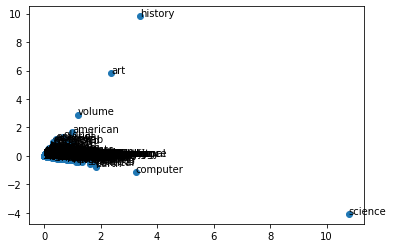

In [12]:
if __name__ == '__main__':
    main()